# Trabajo con imágenes

Por:

* Fernando Gómez Perera - 160300129@ucaribe.edu.mx
* Ricardo Vargas Kumul- 170300227@ucaribe.edu.mx
* Calvin López Álvarez - 170300226@ucaribe.edu.mx

In [1]:
# Bibliotecas a usar
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

 Se definen algunas funciones auxiliares usadas en distintas partes del proceso.

In [2]:
# Leer una imagen para importarla al entorno
def read_img(img_path):
    with open(img_path, 'r') as img:
        img = cv.imread(img_path)
        # Regresar la imagen en escala de grises
        return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Obtener una imagen binarizada a partir de otra mostrando una región específica seleccionada
def get_region(img, region=('bg', 'max', 'min')):
    # Ejecutar un análisis de componentes conectadas para extraer los objetos de la imagen
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4, ltype=cv.CV_16U)
    # Índices de todos los objetos encontrados
    objects = np.arange(num_labels)
    # Extraer el objeto más grande (con área mayor)
    max_object = np.argmax(stats[1::, 4]) + 1
    # Extraer la imagen binarizada elegida
    if region == 'max':
        return np.isin(labels, max_object).astype(np.uint8)
    elif region == 'min':
        # Extraer los objetos más pequeños
        min_objects = np.ma.array(objects[1:], mask=False)
        min_objects.mask[max_object - 1] = True
        min_objects = min_objects.compressed()
        return np.isin(labels, min_objects).astype(np.uint8)
    elif region == 'bg':
        # Extraer el fondo, incluyendo los objetos más pequeños
        bg = np.ma.array(objects, mask=False)
        bg.mask[max_object] = True
        bg = bg.compressed()
        return np.isin(labels, bg).astype(np.uint8)

## Artículos a replicar

Los artículos que usamos como referencia para desarrollar los proyectos son los siguientes:

* ***An improved GVF snake based breast region extrapolation scheme for digital mammograms*** de *Liu et al*.: El objetivo de este artículo es extrapolar la región del busto usando un esquema mejorado de una serpiente Flujo del Vector Gradiente o *Gradient Vector Flow (GVF) snake*.
*  ***A pectoral muscle segmentation algorithm for digital mammograms using Otsu thresholding and multiple regression analysis*** de *Liu et al*: El objetivo de este artículo es segmentar la región del músculo pectoral de la región del pecho combinando el esquema de umbralización de Otsu y el procesamiento matemático morfológico para obtener un borde del músculo pectoral, y usar el análsis de regresión múltiple (*MRA*) para obtener una segmentación precisa del mismo.

### Primer artículo: Extrapolación de la región del busto usando *GVF Snake*

Para llevarlo a cabo, tomamos como referencia el primer artículo de *Liu et al*. [[1]](#ref) En este artículo, los autores proponen un esquema mejorado de una serpiente Flujo del Vector Gradiente o *Gradient Vector Flow (GVF) snake* para poder extrapolar toda la región del busto. El esquema o algoritmo que ellos proponen es el siguiente:

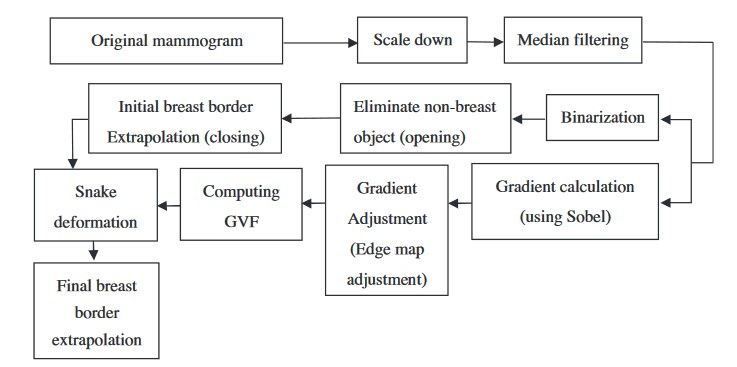

1. Reescalar las imágenes originales de las mamografías.
2. Aplicar un filtro de mediana a las imágenes reescaladas.

En este punto, el proceso se divide en 2 fases:

3. Binarizar la imagen reescalada.
4. Eliminar los objetos que no son de la región del busto.
5. Obtener una extrapolación inicial del borde del busto.

Paralelamente:

3. Aplicar un filtro de Sobel para obtener el campo gradiente de la mamografía reescalada.
4. Ajustar el campo gradiente.
5. Calcular el Flujo del Vector Gradiente (*GVF*).

En este punto, ambos procesos se unen:

6. Aplicar la deformación de la serpiente usando el *GVF* calculado sobre la extrapolación inicial del borde del busto.
7. Obtener la extrapolación final del borde del busto.

De este artículo, solamente usamos la primera ramificación del algoritmo para obtener la región del busto.

### Segunda artículo: Segmentación del músculo pectoral

Para llevarlo a cabo, tomamos como referencia el segundo artículo de *Liu et al*. [[2]](#ref) En este artículo, los autores proponen un esquema que usa el resultado del primer artículo [[1]](#ref) para extraer la región del músculo pectoral. El esquema que propone el artículo es el siguiente:

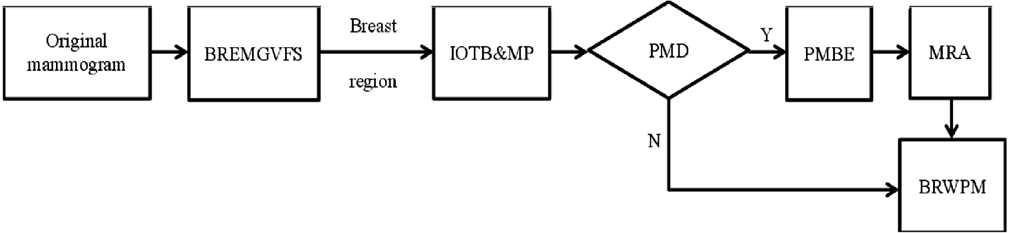

1. Se obtiene el resultado del *GVF Snake* con la región identificada del busto.
2. Se aplica una binarización iterativa de Otsu y procesamiento morfológico para detectar la región del músculo pectoral.
3. Si se detecta la región del músculo pectoral, se extrae el borde y se le aplica regresión múltiple (MRA) para ajustar el borde.
4. Se obtiene la región del pecho sin el músculo pectoral.

Nosotros replicamos solamente la detección del músculo pectoral usando la binarización iterativa de Otsu y el análisis morfológico, y este resultado fue el que usamos para obtener la imagen limpia.

## Tarea 1

### 2. Replica un proceso de limpieza del fondo de la imagen

Este proceso sigue la primera ramificación del algoritmo propuesto en el primer artículo.

Primero, se importan al entorno todas las imágenes originales.

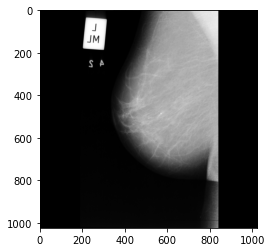

In [3]:
# Ruta de las imágenes originales
base_dir = '../extdata/all-mias/'
all_filenames = os.listdir(base_dir)
imgs_filenames = list()

# Extraer los archivos que corresponden a las imágenes de las mamografías
for filename in all_filenames:
    if filename.endswith('.pgm'):
        imgs_filenames.append(filename)
        
# Reordernar las imágenes alfabéticamente/numéricamente
imgs_filenames.sort()

# Lectura de las imágenes con el parámetro -1 para leer la imagen sin modificar
imgs_orig = list(map(lambda img_filename: read_img(base_dir+img_filename), imgs_filenames))

# Imagen de ejemplo
plt.imshow(imgs_orig[10], cmap='gray')
plt.show()

El artículo tiene varias partes que se contradicen entre sí. Al principio del artículo, los autores mencionan que **primero** se aplica el filtro de mediana sobre las mamografías originales y **después** el reescalamiento de las mamografías. Sin embargo, en el primer diagrama de flujo se puede notar que estos pasos están invertidos.

Hemos probado ambas formas, y llegamos a la conclusión que se obtienen mejores resultados si **primero** se aplica el filtro de mediana y **después** el reescalamiento de las imágenes. Así que estos pasos se llevan a cabo en ese orden.

#### 2.1 Aplicar el filtro de mediana

Los autores sugieren aplicar un filtro de mediana de 3 x 3 pixeles para reducir el ruido de la imagen.

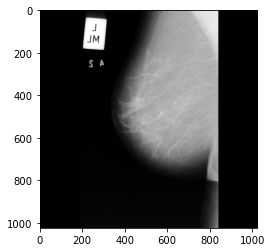

In [4]:
# Aplicar un filtro de mediana a cada una de las imágenes
imgs_filter = list(map(lambda img_orig: cv.medianBlur(img_orig, 3), imgs_orig))

# Imagen de ejemplo
plt.imshow(imgs_filter[10], cmap='gray')
plt.show()

#### 2.2 Reescalar la imagen

Las mamografías se reescalan para hacerlas más pequeñas. Esto permitirá ahorrar tiempo en la ejecución del resto del proceso.

Para mantener la calidad de la extrapolación, los autores sugieren reescalar las imágenes originales de 1024 x 1024 pixeles a 256 x 256 pixeles.

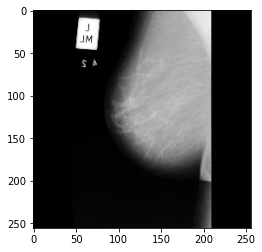

In [5]:
# Reescalar las imágenes para hacerlas más pequeñas (scale down)
imgs_scale = list(map(lambda img_filter: cv.resize(img_filter, (256, 256)), imgs_filter))

# Imagen de ejemplo
plt.imshow(imgs_scale[10], cmap='gray')
plt.show()

#### 2.3 Binarización de las imágenes

Este paso permite obtener un contorno aproximado. Para ello, los autores proponen obtener un umbrarl $T$, el cual será equivalente al valor medio de gris de la imagen.

La fórmula para calcular el umbral $T$ es la siguiente:

$$T = 0.2 \cdot  \frac{\sum_{n = 0}^{255} n \cdot H(n)}{\sum_{n = 0}^{255} H(n)}$$

donde $n$ es el valor del nivel de gris, el cual va de 0 a 255, y $H(n)$ es el número de pixeles con el valor de pixel $n$ dentro de la imagen, el cual se obtiene de su histograma.

Para binarizarla, se sigue la siguiente fórmula:

$$
\text{IB}(x, y)  = \begin{cases}
    1,\text{ si } I(x,y) \geq T,\\
    0, \text{ de otra forma}.
  \end{cases}
$$

donde $I(x, y)$ es el valor de intensidad de cada pixel en la imagen.

De esta forma, la imagen quedará divida en la región de fondo (con valor de pixel 0) y la región de objetos (con valor de pixel 1).

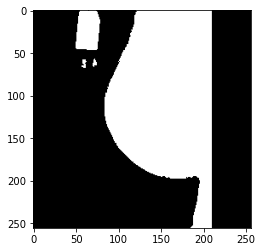

In [6]:
# Obtener del umbral a partir del valor del nivel de gris en la imagen
def T(img):
    H_n = cv.calcHist([img], [0], None, histSize=[256], ranges=(0, 256), accumulate=False).ravel()
    return 0.2 * np.sum(np.arange(0, 256) * H_n) / np.sum(H_n)

# Binarizar la imagen
def binarization(img):
    return np.where(img >= T(img), 1, 0).astype(np.uint8)

# Binarización de las imágenes
imgs_bin = list(map(lambda img_scale: binarization(img_scale), imgs_scale))

# Imagen de ejemplo
plt.imshow(imgs_bin[10], cmap='gray')
plt.show()

#### 2.4 Eliminar los objetos que no son parte de la región del busto.

Este proceso está compuesto de 2 partes:

##### 2.4.1 Procesamiento morfológico

Tomando como base el ejemplo de la imagen binarizada, se puede notar que además de la región del busto, hay pequeñas regiones que no son de interés. Para eliminarlos, los autores proponen en su algoritmo aplicar la operación morfológica de apertura, la cual está compuesta de 2 transformaciones morfológicas:

* La **erosión**, la cual, como dice su nombre, erosiona los límites del objeto en primer plano (siempre trata de mantener el primer plano en blanco).
* La **dilatación**, que es lo opuesto a la erosión. Esto provoca que aumente la región blanca en la imagen o aumente el tamaño del objeto en primer plano.

Para ello, la función toma un kernel que se desliza por la imagen, y modfica el valor de un pixel de acuerdo con los siguientes criterios:

* En el caso de la **erosión**, el valor del pixel será de 1 solamente si todos los pixeles bajo el kernel son 1. Sino, se erosiona (se vuelve 0).
* En el caso de la **dilatación**, el valor del pixel será de 1 si al menos un pixel bajo el kernel es de 1.

Los autores proponen usar un elemento estructurado (kernel) formado por un disco de radio 2 pixeles.

In [7]:
# Creación del kernel compuesto por un disco de radio 2
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0
kernel

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

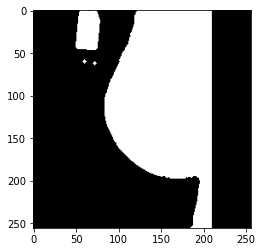

In [8]:
# Aplicar el procesamiento morfológico de apertura sobre las imágenes binarizadas
imgs_mpo = list(map(lambda img_bin: cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel), imgs_bin))

# Imagen de ejemplo
plt.imshow(imgs_mpo[10], cmap='gray')
plt.show()

##### 2.4.2 Extracción de la región del busto

Aún después de aplicar el procesamiento morfológico, y como se visualiza en la imagen de ejemplo, quedan todavía elementos que no corresponden al área del busto. Sin embargo, claramente se puede notar que su tamaño es menor en comparación a esta área.

Por ello, para eliminar los elementos faltantes, los autores proponen usar las características del objeto busto en la imagen mamográfica para etiquetar los objetos, y después extraer el objeto de mayor tamaño de la imagen binarizada. Y aquellos objetos que no correspondan al área del busto se modifican para volverse parte del fondo en dicha imagen. Finalmente, estos objetos también se modifican en la imagen reducida $I$, estableciendo sus valores de intensidad igual al nivel de gris medio del área que no pertenece al área del busto en ella.

Sin embargo, los autores no explican cómo llevaron a cabo este proceso. Por lo que nosotros implementamos un proceso que busca replicar los puntos que ellos mencionan.

Este proceso se compone de los siguientes pasos, aplicados a cada mamografía:

1. Obtener la región del fondo de la imagen binarizada procesada con la operación morfológica de apertura, que es equivalente a la región que no es del busto.
2. Obtener las intensidades de esta región, y calcular su nivel de gris medio
3. Modificar las intensidades de los objetos más pequeños detectados en la imagen binarizada original con el valor del nivel de gris medio en la imagen escalada.
4. Obtener la región del busto, que resulta ser la región más grande dentro de la imagen binarizada procesada con la operación morfológica de apertura.
5. Regresar la imagen escalada limpia y la imagen binarizada limpia.

In [9]:
# Extraer la región del busto
def extract_breast_region(img_scale, img_bin, img_mpo):
    # Obtener la región que no pertenece a la región del busto
    bg_region = get_region(img_mpo, region='bg')
    # Obtener las intensidades de la región que no pertenece a la región del busto
    bg_values = np.ma.array(img_scale, mask=False)
    bg_values.mask = np.where(bg_region == 1, False, True)
    # Calcular el nivel de gris medio de estas áreas
    mean_gray_level = np.mean(bg_values)
    # Modificar las intensidades en los objetos más pequeños
    smaller_objects = get_region(img_mpo, region='bg')
    mod_img_scale = np.where(smaller_objects == 1, mean_gray_level, img_scale).astype(np.uint8)
    # Obtener la región más grande, que corresponde a la región del busto
    breast_region = get_region(img_mpo, region='max')
    return mod_img_scale, breast_region

In [10]:
# Eliminar los objetos que no son parte de la región del busto en las imágenes escaladas
imgs_clean = list()
imgs_bin_clean = list()

for img_scale, img_bin, img_mpo in zip(imgs_scale, imgs_bin, imgs_mpo):
    img_clean, img_bin_clean = extract_breast_region(img_scale, img_bin, img_mpo)
    imgs_clean.append(img_clean)
    imgs_bin_clean.append(img_bin_clean)

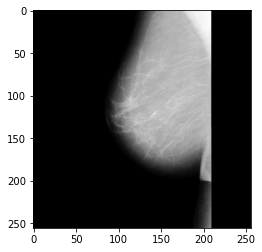

In [11]:
# Imagen de ejemplo (Imagen escalada limpia)
plt.imshow(imgs_clean[10], cmap='gray')
plt.show()

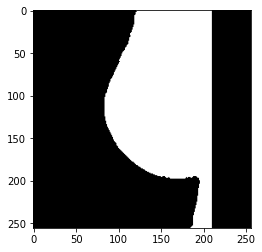

In [12]:
# Imagen de ejemplo (Imagen binarizada limpia)
plt.imshow(imgs_bin_clean[10], cmap='gray')
plt.show()

Finalmente, todas las imágenes limpias se almacenan en el directorio de la aplicación para que puedan usarse dentro de ella.

In [13]:
# Almacenar las mamografías limpias en la carpeta de la aplicación
app_dir = '../app/img/'
# Obtener los números de imagen en el orden en el que se importaron al entorno
find_nums = re.compile('\d{3}')
imgs_nums = list(map(lambda filename: int(find_nums.findall(filename)[0]), imgs_filenames))

for img_scale, img_clean, img_bin_clean, img_num in zip(imgs_scale, imgs_clean, imgs_bin_clean, imgs_nums):
    cv.imwrite(app_dir + str(img_num) + '_scale.png', img_scale)
    cv.imwrite(app_dir + str(img_num) + '_clean.png', img_clean)
    cv.imwrite(app_dir + str(img_num) + '_bin_clean.png', np.where(img_bin_clean == 1, 255, 0))

## Tarea 2: Intento con GVF Snake

### 3. Replica un proceso que elimine el músculo pectoral

Antes de llevar a cabo el proceso de eliminación del músculo pectoral, es necesario terminar de extraer el contorno de la región del busto siguiendo el diagrama de flujo del punto anterior.

Este fue nuestro primer intento para realizar la eliminación del musculo pectoral, sin embargo, no logramos obtener el resultado esperado debido a cierta ambigüedad que existe dentro del documento en el cual nos basamos. Se realizaron varios cambios y distintos intentos para remediar aquello que el texto no explica, sin embargo, nos fue imposible hacer que funcionara con este acercamiento al problema.

#### 3.1 Obtener el contorno final de la región del busto usando *GVF Snake*

##### 3.1.1 Extraer el contorno inicial de la región del busto

El siguiente paso es extraer el contorno inicial de la región del busto usando la siguiente fórmula:

$$\text{IB}_{\text{edge}} = \text{IB}_{\text{fin}} - \text{IB}_{\text{ero}}$$

Donde $\text{IB}_{\text{fin}}$ es la imagen binarizada limpia obtenida en el paso anterior, e $\text{IB}_{\text{ero}}$ es la imagen resultante de aplicar la operación de erosión morfológica sobre  $\text{IB}_{\text{fin}}$.

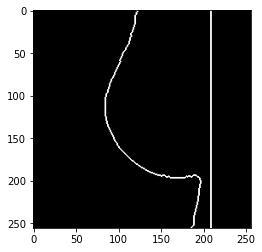

In [14]:
# Extrapolación inicial del borde de la región del busto
def extract_initial_breast_border(img_bin_clean, erode_iterations=1):
    return img_bin_clean - cv.erode(img_bin_clean, kernel, iterations=erode_iterations)

# Obtener la extrapolación inicial del borde de la región del busto de las imágenes binarizadas limpias
imgs_edges = list(map(lambda img_bin_clean: extract_initial_breast_border(img_bin_clean, erode_iterations=1), imgs_bin_clean))

# Imagen de ejemplo
plt.imshow(imgs_edges[10], cmap='gray')
plt.show()

#####  3.1.2 Cálculo del gradiente usando el filtro de Sobel

Para poder aplicar el *GVF Snake*, primero es necesario obtener el gradiente de los pixeles de cada imagen limpia usando el filtro de Sobel.

El filtro de Sobel sigue la fórmula:

$$G(x, y) = |G_x(x, y)| + |G_y(x, y)|$$

donde $G_x(x, y)$ y $G_y(x, y)$ indican los cambios en la componente horizontal y vertical del pixel en la posición $(x, y) $ de cada imagen.

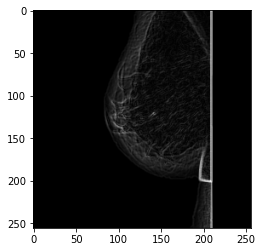

In [15]:
# Calcular el gradiente de los pixeles de una imagen usando el filtro de Sobel
def Sobel_filter(img):
    # Cálculo de los gradientes de cada componente
    grad_x = cv.Sobel(img, cv.CV_64F, dx=1, dy=0)
    grad_y = cv.Sobel(img, cv.CV_64F, dx=0, dy=1)
    # Convertir los valores de las componentes a su valor absoluto
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    # Calcular el gradiente usando la fórmula del filtro de Sobel
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return abs_grad_x, abs_grad_y, grad

# Calcular el gradiente de cada imagen y sus componentes
imgs_grad_x = list()
imgs_grad_y = list()
imgs_grad = list()

for img_clean in imgs_clean:
    grad_x, grad_y, grad = Sobel_filter(img_clean)
    imgs_grad_x.append(grad_x)
    imgs_grad_y.append(grad_y)
    imgs_grad.append(grad)

# Imagen de ejemplo
plt.imshow(imgs_grad[10], cmap='gray')
plt.show()

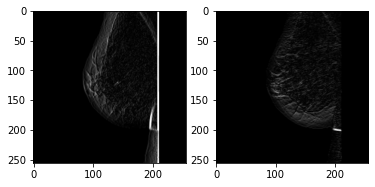

In [16]:
plt.subplot(121)
plt.imshow(imgs_grad_x[10], cmap='gray')
plt.subplot(122)
plt.imshow(imgs_grad_y[10], cmap='gray')
plt.show()

#####  3.1.2 Ajuste del gradiente

Los autores proponen una operación de ajuste sobre el gradiente obtenido en el paso anterior, pues mencionan que aplicar *GVF Snake* directamente sobre el gradiente podría tener como resultado un borde de la región del busto malo. La fórmula que ellos proponen es la siguiente:

$$G_\text{adjust}(x, y) = w_0 \cdot \frac{G(x, y) - G_\text{min}}{G_\text{max} - G_\text{min}} + w_1 \cdot \frac{T - I(x, y)}{255}$$

Donde:
* $w_0$ y $w_1$ son pesos asignados por el usuario, los cuales toman los valores $0 \leq w_0 \leq 1$ y $w_1 = 1 - w_0$ (los autores mencionan que $w_0  = 0.63$ y que este dato es experimental).
* $G_\text{max}$ y $G_\text{min}$ son el valor máximo y mínimo de la magnitud del campo gradiente $G$, respectivamente.
* $T$ es el umbral obtenido el paso 2.3.
* $I(x, y)$ es la imagen limpia.

Según los autores, esta operación debería tener como resultado una imagen donde cada pixel adquiere un valor entre 0 y 1, y que esto debería ayudar a que el borde del busto se acerque más al borde real, pues esta operación disminuye el gradiente relativo de la región clara y aumenta el gradiente relativo de la región oscura.

Sin embargo, al replicar esta operación, nosotros obtuvimos valores negativos, los cuales no se ajustan a lo que mencionan los autores, y afectan fuertemente los resultados obtenido más adelante. Un ejemplo se muestra a continuación:

In [17]:
# Ajuste del gradiente sobre una imagen de muestra
test_img = imgs_clean[10].copy()
w0 = 0.63
w1 = 1 - w0
grad_magn = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))

grad_adjust = w0 * ((grad - np.min(grad_magn)) / (np.max(grad_magn) - np.min(grad_magn))) + w1 * ((T(test_img) - test_img) / 255)

# Valor mínimo obtenido de esta operación
grad_adjust.min()

-0.3154984877642463

Como los autores no mencionan nada sobre cómo manejar estos valores negativos, decidimos usar el gradiente obtenido del filtro de Sobel para aplicar el *GVF Snake*.

#####  3.1.3 Aplicar *GVF Snake*

Primero resulta conveniente explicar un poco el concepto de *serpiente* en este contexto.

###### Serpientes clásicas en la segmentación de imágenes

Llamadas también como *modelo activo del contorno*, permite obtener una curva deformable en el dominio espacial de la imagen minimizando una función de energía. La forma de la serpiente es modificada por las fuerzas internas que intentan mantener la suavidad de la forma de la serpiente, y también es modificada por las fuerzas externas que atraen a la serpiente hacia las característica destacadas de la imagen.

Este modelo tiene 2 incovenientes:

1. La serpiente inicial debe estar bastante cerca del límite verdadero.
2. El contorno activo no puede deformarse fácilmente en puntos de contorno cóncavos.

###### Serpiente *GVF*

Es una mejora del modelo clásico de serpíente., con el objetivo de obtener un mejor rendimiento en la segmentación de imágenes.

La idea detrás de este modelo es agrandar el rango de influencia de cada fuerza externa creando un campo del flujo del vector gradientepara sustituir el cambo de fuerzas externas de la serpiente clásica.

Este modelo mejora el rango restringido de captura y la débil convergencia de la serpiente clásica. Pero aún depende de la distribución del gradiente de la imagen.

La función de energía usada en el modelo del *GVF snake* es la siguiente:

$$\varepsilon = \int \int \mu (u_x^2 + u_y^2 + v_x^2 + v_y^2) + |\nabla f|^2 |V -  \nabla f|^2 dx dy$$

Donde:

* $\mu$ es un parámetro de regularización.
* $f(x, y)$ es un mapa de contornos.
* V es el campo del flujo del vector gradiente (*GVF*) tal que $V(x, y) = (u(x, y), v(x, y))$, el cual minimiza la función de energía.

El campo GVF se puede obtener resolviendo las siguientes ecuaciones de Euler-Lagrange:

$$\mu \nabla^2 u - (u - f_x)(f_x^2 + f_y^2) = 0$$

$$\mu \nabla^2 v -  (v - f_y)(f_x^2 + f_y^2) = 0$$

donde $\nabla^2$ es el operador Laplaciano.

Las ecuaciones anteriores se pueden resolver tratando $u$ y $v$ como funciones del tiempo:

$$u_t(x, y, t) = \mu \nabla^2 u(x, y, t)  - (u(x, y, t) - f_x(x, y) )(f_x(x, y) ^2 + f_y(x, y) ^2)$$

$$v_t(x, y, t) = \mu \nabla^2 v(x, y, t)  -  (v(x, y, t) - f_y(x, y) )(f_x(x, y) ^2 + f_y(x, y) ^2)$$

###### Modelo propuesto de la serpiente GVF

In [18]:
fx = cv.Sobel(grad, cv.CV_64F, dx=1, dy=0)
fy = cv.Sobel(grad, cv.CV_64F, dx=0, dy=1)

u = fx.copy()
v = fy.copy()

lamb = 0.1

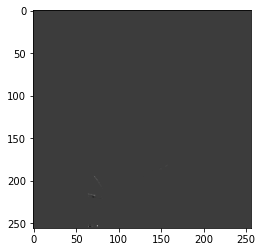

In [19]:
for i in range(5):
    u = lamb * cv.Laplacian(u, cv.CV_64F) - (u - fx) * (fx*+2 + fy**2)

for i in range(5):
    v = lamb * cv.Laplacian(v, cv.CV_64F) - (v - fy) * (fx*+2 + fy**2)
    
plt.imshow(u, cmap='gray')
plt.show()

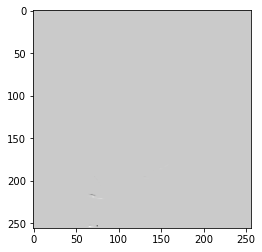

In [20]:
plt.imshow(v, cmap='gray')
plt.show()

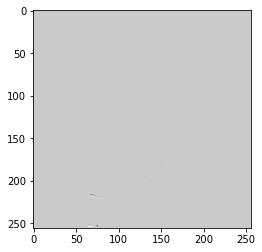

In [21]:
V = cv.addWeighted(u, 1, v, 1, 0)

plt.imshow(V, cmap='gray')
plt.show()

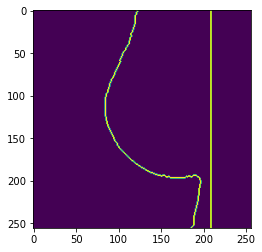

In [22]:
plt.imshow(imgs_edges[10])

In [23]:
X_s = imgs_edges[10].copy()
alpha = 0.001
beta = 0.001

for i in range(5):
    X_s_2 = cv.Laplacian(X_s, cv.CV_64F)
    X_s_4 = cv.Laplacian(X_s_2, cv.CV_64F)
    X_s = alpha * X_s_2 - beta * X_s_4 + V

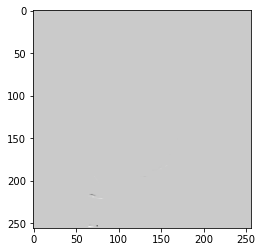

In [24]:
plt.imshow(X_s, cmap='gray')
plt.show()

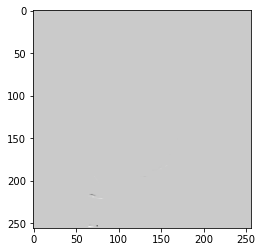

In [25]:
X = imgs_clean[10] + X_s

plt.imshow(X, cmap='gray')
plt.show()

En este punto decidimos desistir de utilizar este acercamiento para la resolución del problema, aunque de conseguirlo obtendríamos una precisión bastante alta.

## Tarea 2: Intento con Otsu Threshold

### 3. Replica un proceso que elimine el músculo pectoral

En este caso, usamos el flujo del segundo artículo para extraer la región pectoral del músculo.

Al notar que con GVF Snake no estábamos obteniendo los resultados que necesitábamos decidimos cambiar de estrategia y utilizar un documento que usara un método distinto para obtener el músculo.

En este caso, nos basamos del artículo de *Kar* [[3]](#ref), donde se explica el algoritmo iterativo de la umbralización de Otsu. Sin embargo, este algoritmo está adecuado para poder aplicar el procesamiento morfológico de apertura después de calcular la umbralización, ya que así lo pide el artículo de *Kar et al.* [[2]](#ref).

In [26]:
# Extraer la región del músculo pectoral
def extract_pectoral_muscle_region(img):
    # Se calcula el valor del umbral de Otsu sobre la imagen
    thresh, img_bin = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # Se aplica procesamiento morfológico de apertura para limpiar algunas regiones blancas
    img_bin = cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel)
    # Inicializar el umbral de la iteración anterior
    last_thresh = 0
    # Calcular el umbral de Otsu de forma iterativa
    while last_thresh != thresh:
        # Extraer los pixeles del fondo y del primer plano
        fg = np.ma.array(img, mask=False)
        bg = np.ma.array(img, mask=False)
        fg.mask = np.where(img_bin == 255, False, True)
        bg.mask = np.where(img_bin == 0, False, True)
        # Calcular el promedio de estas 2 regiones
        mean_fg = np.mean(fg)
        mean_bg = np.mean(bg)
        # Extraer los pixeles que se encuentren entre estos 2 promedios (región TBD)
        img_tbd_region = np.where(np.logical_and(img > mean_fg, img > mean_bg), img, 0).astype(np.uint8)
        # Obtener un nuevo umbral usando esta región
        last_thresh = thresh
        thresh, img_bin = cv.threshold(img_tbd_region, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        img_bin = cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel)
    # Extraer la región más grande usando análisis de componentes conectadas
    muscle_region = get_region(img_bin, 'max')
    # Modificar las intensidades de esta región a cero
    mod_img = np.where(muscle_region == 1, 0, img)
    return mod_img, muscle_region

Con esta función se logra obtener la región del músculo pectoral identificada y la imagen limpia.

In [27]:
# Eliminar los objetos que no son parte de la región del busto en las imágenes escaladas
imgs_clean_2 = list()
imgs_bin_clean_2 = list()

for img in imgs_clean:
    img_clean, img_bin_clean = extract_pectoral_muscle_region(img)
    imgs_clean_2.append(img_clean)
    imgs_bin_clean_2.append(img_bin_clean)

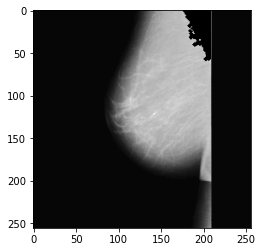

In [28]:
# Imagen de ejemplo (Imagen escalada limpia)
plt.imshow(imgs_clean_2[10], cmap='gray')
plt.show()

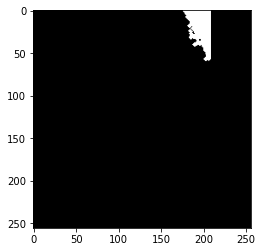

In [29]:
# Imagen de ejemplo (Imagen binarizada limpia)
plt.imshow(imgs_bin_clean_2[10], cmap='gray')
plt.show()

Finalmente, las imágenes limpias se almacenan en el directorio de la aplicación para poder ser usadas dentro de ella.

In [30]:
# Almacenar las mamografías limpias en la carpeta de la aplicación
for img, img_bin_clean, img_num in zip(imgs_clean_2, imgs_bin_clean_2, imgs_nums):
    cv.imwrite(app_dir + str(img_num) + '_clean_2.png', img)
    cv.imwrite(app_dir + str(img_num) + '_bin_clean_2.png', np.where(img_bin_clean == 1, 255, 0))

## Tarea 3

In [31]:
with open('../extdata/all-mias/info.csv') as file:
    info = pd.read_csv(file)
    
info

,ref,bg_tissue,abnorm,severity,x,y,approx_radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [32]:
bg_tissue = info[['ref', 'bg_tissue']].drop_duplicates(ignore_index=True) 

In [34]:
X = np.reshape(imgs_clean_2, (322, 256*256))
y = bg_tissue['bg_tissue'].values.reshape(-1)
print(X.shape, y.shape)

(322, 65536) (322,)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100, stratify=y)

In [50]:
pca = PCA(n_components=256, whiten=True).fit(X)

Número de componentes a elegir:  12
Varianza total explicada:  0.757537616599022


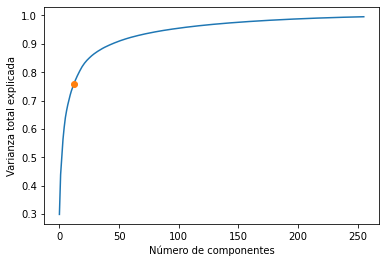

In [51]:
expl_var = np.cumsum(pca.explained_variance_ratio_)

for i, cum_ev in enumerate(expl_var):
    if cum_ev >= 0.75:
        print("Número de componentes a elegir: ", i)
        print("Varianza total explicada: ", cum_ev)
        svd_comp = [i, cum_ev]
        break
        
plt.plot(expl_var)
plt.plot(svd_comp[0], svd_comp[1], marker="o")
plt.xlabel('Número de componentes')
plt.ylabel('Varianza total explicada')
plt.show()

In [52]:
pca = PCA(n_components=12, whiten=True).fit(X)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [53]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

In [54]:
print(clf.best_estimator_)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

SVC(C=50000.0, class_weight='balanced', gamma=0.0001)
              precision    recall  f1-score   support

           D       0.54      0.65      0.59        23
           F       0.67      0.57      0.62        21
           G       0.47      0.43      0.45        21

    accuracy                           0.55        65
   macro avg       0.56      0.55      0.55        65
weighted avg       0.56      0.55      0.55        65

[[15  3  5]
 [ 4 12  5]
 [ 9  3  9]]


In [55]:
param_grid = {'n_estimators': [10, 20, 50, 100],}
rf = GridSearchCV(
    RandomForestClassifier(), param_grid
)
rf = rf.fit(X_train_pca, y_train)

y_pred = rf.predict(X_test_pca)

In [56]:
print(rf.best_estimator_)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

RandomForestClassifier()
              precision    recall  f1-score   support

           D       0.59      0.74      0.65        23
           F       0.75      0.71      0.73        21
           G       0.56      0.43      0.49        21

    accuracy                           0.63        65
   macro avg       0.63      0.63      0.62        65
weighted avg       0.63      0.63      0.62        65

[[17  2  4]
 [ 3 15  3]
 [ 9  3  9]]


In [57]:
param_grid = {'n_estimators': [10, 20, 50, 100],}
rf = GridSearchCV(
    RandomForestClassifier(), param_grid
)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [58]:
print(rf.best_estimator_)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

RandomForestClassifier(n_estimators=50)
              precision    recall  f1-score   support

           D       0.62      0.65      0.64        23
           F       0.78      0.67      0.72        21
           G       0.48      0.52      0.50        21

    accuracy                           0.62        65
   macro avg       0.63      0.61      0.62        65
weighted avg       0.63      0.62      0.62        65

[[15  0  8]
 [ 3 14  4]
 [ 6  4 11]]


## <a name="ref"></a>  Referencias

1. Liu, C.-C., Tsai, C.-Y., Tsui, T.-S., & Yu, S.-S. (2012). An improved GVF snake based breast region extrapolation scheme for digital mammograms. Expert Systems with Applications, 39(4), 4505-4510. https://doi.org/10.1016/j.eswa.2011.09.136

2. Liu, C.-C., Tsai, C.-Y., Liu, J., Yu, C.-Y., & Yu, S.-S. (2012). A pectoral muscle segmentation algorithm for digital mammograms using Otsu thresholding and multiple regression analysis. Computers & Mathematics with Applications, 64(5), 1100-1107. https://doi.org/10.1016/j.camwa.2012.03.028

3. Kar, C. (2016). Comparative Analysis between Iterative Threshold Technique and Otsu’s Method. International Journal of Advanced Research in Computer and Communication Engineering, 5(2), 208-212. https://doi.org/10.17148/IJARCCE.2016.5244

3. OpenCV. (2021, 9 marzo). OpenCV: Morphological Transformations. https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html